# A3 - Analyzing Selected Repositories
This notebooks analyzes features from repositories that where selected for futher analysis, i.e. the repositories that had Python or Jupyter Notebook as a Primary Language.

Besides their name, owner and description the following features were collected with each repository:
 - Primary language and number of languages in total
 - Number of contributors
 - Number, types and frequency of Commits
 - Number of branches and tags
 - Number of pull requests and issues
 - Number of watchers, forks, stargazers and releases
 - Disk usage and the dates the repository was created and last pushed


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from src.db.database import connect, Notebook, PythonFile
from src.helpers.h7_analysis_helpers import get_python_version
from src.config.states import REP_COLLECTED, REP_FILTERED, REP_DISCARDED
from src.config.states import NB_AGGREGATED, PF_AGGREGATED
from src.helpers.h7_analysis_helpers import calculate_frequencies

In [2]:
with connect() as session:
    repositories = pd.read_sql_table("repositories", session.connection())

selected = repositories[(~repositories.state.isin([REP_COLLECTED, REP_FILTERED, REP_DISCARDED]))]
print('Total of Repositories Selected: ', len(selected))

Total of Repositories Selected:  10


In [3]:
with connect() as session:
    notebooks = pd.read_sql_table("notebooks", session.connection())
    python_files = pd.read_sql_table("python_files", session.connection())

print('Out of the {} selected repositories we found:'.format(len(selected)))
print('- A total of Notebooks:', len(notebooks))
print('- A total of Python Files:', len(python_files))

Out of the 10 selected repositories we found:
- A total of Notebooks: 308
- A total of Python Files: 187


#### Jupyter Notebooks
 Which languages are they in? Which versions?

Out of 308 Notebooks:
- Python Notebooks: 295
- R Notebooks: 12
- Unkwon language Notebooks: 1


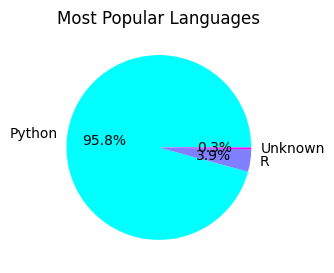

In [4]:
fig1, ax1 = plt.subplots( figsize=(10,3))
languages = notebooks.language\
    .value_counts(dropna=False)\
    .rename_axis('primary_language')\
    .to_frame("Notebooks").reset_index(drop=False)\
    .sort_values(by='Notebooks', ascending=False)


languages.plot.pie(ax=ax1, y="Notebooks", title="Most Popular Languages",
             labels=["Python","R","Unknown"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()


print("Out of {} Notebooks:".format(len(notebooks)))
print('- Python Notebooks:', languages["Notebooks"][0])
print('- R Notebooks:', languages["Notebooks"][1])
print('- Unkwon language Notebooks:', languages["Notebooks"][2])

Since most notebooks are in Python, henceforth we will only analyze those in Python

In [5]:
python_notebooks = notebooks.query("language == 'python'")

The most common Python Versions and Notebook Formats are:

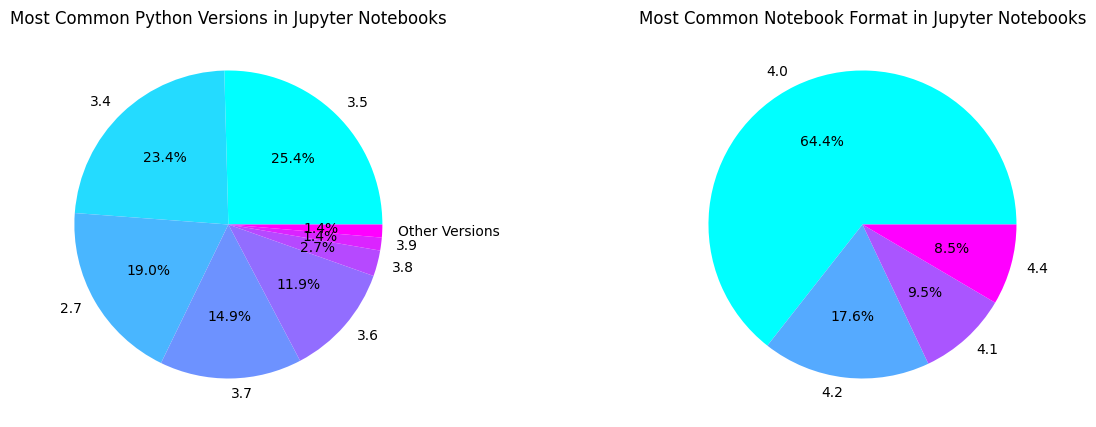

In [6]:
fig2, ax2 = plt.subplots(ncols=2, figsize=(15,5))
python_version = get_python_version(python_notebooks)
python_version.plot.pie(ax=ax2[0], y="Notebooks", title="Most Common Python Versions in Jupyter Notebooks",
             labels=python_version["Versions"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()

nb_format = python_notebooks.nbformat.value_counts(dropna=False)\
        .rename_axis('Formats').to_frame("Notebooks").reset_index(level=0)
nb_format.plot.pie(ax=ax2[1], y="Notebooks", title="Most Common Notebook Format in Jupyter Notebooks",
             labels=nb_format["Formats"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()



#### Valid Notebooks
Before extracting data from the notebooks we excluded those that were empty or did not have a kernel or notebook format.
After the extraction, those that did not have any processing errors are considered valid notebooks for the next analysis.

In [7]:
with connect() as session:
    valid_notebooks = session.query(Notebook)\
        .filter(Notebook.state == NB_AGGREGATED).count()

    print('Out of the {} Notebooks:'.format(len(python_notebooks)))
    print('- Valid Python Notebooks: {}'.format(valid_notebooks))
    print('- Invalid Python Notebooks: {}'.format(len(python_notebooks)-valid_notebooks))

Out of the 295 Notebooks:
- Valid Python Notebooks: 265
- Invalid Python Notebooks: 30


#### 1.2.2 - Python Files
We excluded empty python files from extraction. Those that did not have any processing errors are considered valid python files for the next analysis.

In [8]:
with connect() as session:
    valid_python_files = session.query(PythonFile)\
        .filter(PythonFile.state == PF_AGGREGATED).count()

    print('Out of the {} Python Files:'.format(len(python_files)))
    print('- Valid Python Files: {}'.format(valid_python_files))
    print('- Invalid Python Files: {}'.format(len(python_files)-valid_python_files))

Out of the 187 Python Files:
- Valid Python Files: 152
- Invalid Python Files: 35


### Contributors

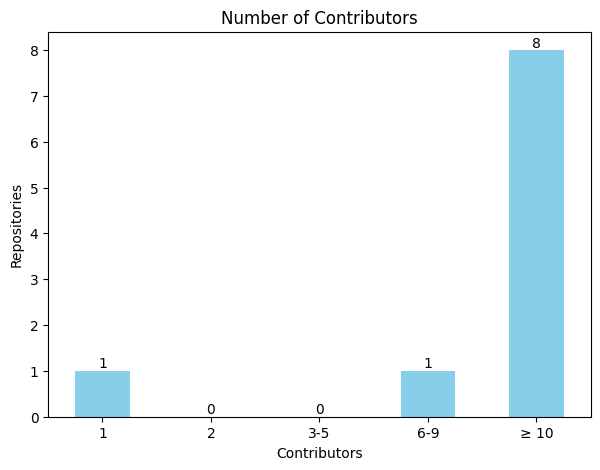

In [9]:
fig3, ax3 = plt.subplots( figsize=(7, 5))

contributors = selected.contributors\
    .value_counts(dropna=False, bins = [0,1,2,5,9, 100000])\
    .sort_index().to_frame("Repositories")
contributors.plot.bar(title='Number of Contributors', color='skyblue', ax=ax3,
                   xlabel='Contributors', ylabel='Repositories').get_legend().remove()

ax3.set_xticks(ticks=[0, 1, 2, 3, 4], labels=['1','2', '3-5', '6-9', '≥ 10'], rotation=0)
ax3.bar_label(ax3.containers[0], label_type='edge');

### Commits

### Types of Commits

In [10]:
with connect() as session:
    all_commits = pd.read_sql_table("commits", session.connection())
normal_commits = all_commits[all_commits.type=="commit"]
merge_commits = all_commits[all_commits.type=="merge"]
print("In all {} repositories {} commits were found, that are divided in:".format(len(selected), len(all_commits)))
print("- Normal Commits: {}".format(len(normal_commits)))
print("- Merge Commits: {}".format(len(merge_commits)))

In all 10 repositories 3938 commits were found, that are divided in:
- Normal Commits: 3350
- Merge Commits: 588


### Average of Commits

In [11]:
normal_commits_per_repository = normal_commits.repository_id.value_counts()\
    .rename_axis('repository_id').to_frame("commits").reset_index(drop=False).sort_values(by='repository_id')
normal_mean =  normal_commits_per_repository.commits.mean()

merge_commits_per_repository = merge_commits.repository_id.value_counts()\
    .rename_axis('repository_id').to_frame("commits").reset_index(drop=False).sort_values(by='repository_id')
merge_mean =  merge_commits_per_repository.commits.mean()

print("Considering all %d repositories, on average each repository"
      " has %.2f normal commits and %.2f merge commits."
      % (len(selected), normal_mean, merge_mean))

Considering all 10 repositories, on average each repository has 418.75 normal commits and 84.00 merge commits.


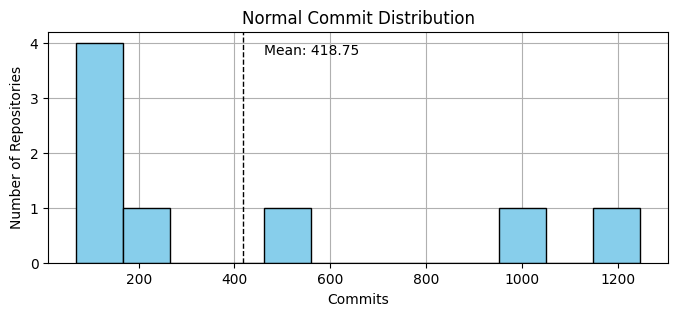

In [12]:
fig4, ax4 = plt.subplots(figsize=(8,3))
normal_commits_per_repository.commits.hist(ax=ax4, bins= 12, color='skyblue', edgecolor='k',zorder=2)
plt.title('Normal Commit Distribution')
plt.xlabel('Commits')
plt.ylabel('Number of Repositories')
plt.axvline(normal_mean, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim2 = plt.ylim()
plt.text(normal_mean*1.1, max_ylim2*0.9, 'Mean: {:.2f}'.format(normal_mean));

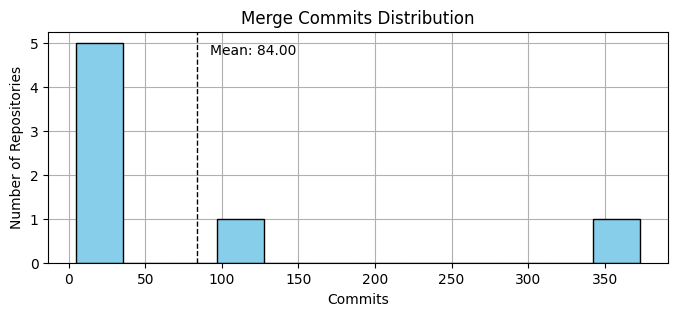

In [13]:
fig5, ax5 = plt.subplots(figsize=(8,3))
merge_commits_per_repository.commits.hist(ax=ax5, bins= 12, color='skyblue', edgecolor='k',zorder=2)
plt.title('Merge Commits Distribution')
plt.xlabel('Commits')
plt.ylabel('Number of Repositories')
plt.axvline(merge_mean, color='k', linestyle='dashed', linewidth=1)
min_ylim3, max_ylim3 = plt.ylim()
plt.text(merge_mean*1.1, max_ylim3*0.9, 'Mean: {:.2f}'.format(merge_mean));

### How often are commits made?
In this section we investigate how long it takes from one commit to another.

In [14]:
repositories_with_normal_commits = calculate_frequencies(normal_commits_per_repository, normal_commits)
normal_mean = repositories_with_normal_commits.frequency_timedelta.mean()

repositories_with_merge_commits = calculate_frequencies(merge_commits_per_repository, merge_commits)
merge_mean = repositories_with_merge_commits.frequency_timedelta.mean()

print("Considering all {} repositories:".format(len(normal_commits_per_repository)))
print("- Normal Commits are made on average every {}.".format(normal_mean))
print("- Merge Commits are made on average every {}.".format(merge_mean))

Considering all 8 repositories:
- Normal Commits are made on average every 8 days 18:33:19.143806135.
- Merge Commits are made on average every 47 days 12:22:45.214243044.


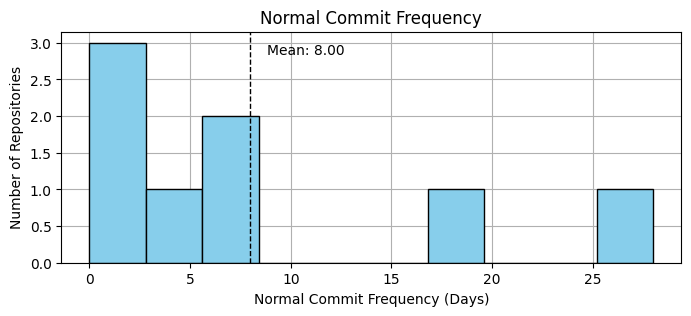

In [15]:
fig6, ax6 = plt.subplots(figsize=(8,3))
mean = normal_mean.days
repositories_with_normal_commits.frequency_in_days.hist(ax=ax6, color='skyblue', edgecolor='k',zorder=2)
plt.title('Normal Commit Frequency')
plt.xlabel('Normal Commit Frequency (Days)')
plt.ylabel('Number of Repositories')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
min_ylim4, max_ylim4 = plt.ylim()
plt.text(mean*1.1, max_ylim4*0.9, 'Mean: {:.2f}'.format(mean));

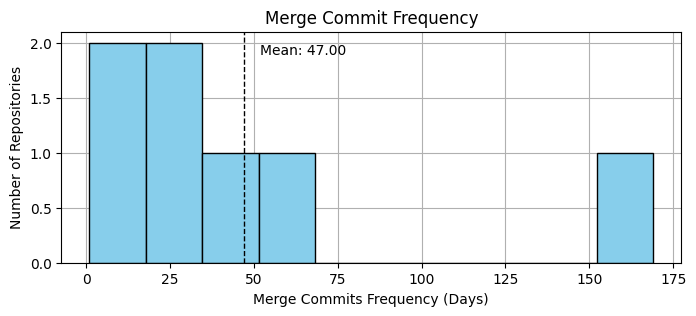

In [16]:
fig7, ax7 = plt.subplots(figsize=(8,3))
mean = merge_mean.days
repositories_with_merge_commits.frequency_in_days.hist(ax=ax7, color='skyblue', edgecolor='k',zorder=2)
plt.title('Merge Commit Frequency')
plt.xlabel('Merge Commits Frequency (Days)')
plt.ylabel('Number of Repositories')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
min_ylim5, max_ylim5 = plt.ylim()
plt.text(mean*1.1, max_ylim5*0.9, 'Mean: {:.2f}'.format(mean));

### Branchs and Tags

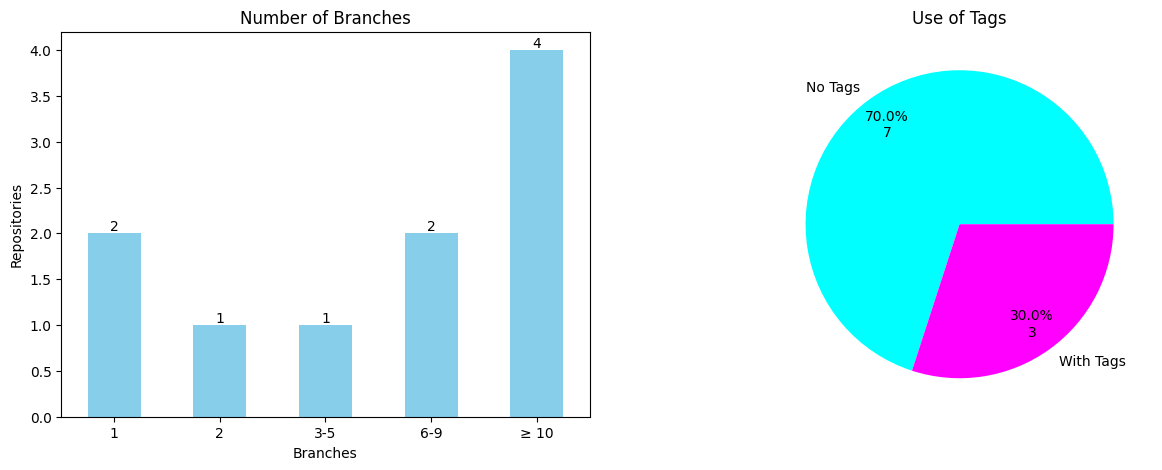

In [17]:
fig8, ax8 = plt.subplots( figsize=(15, 5), ncols=2)

branches = selected.branches\
    .value_counts(dropna=False, bins = [0,1,2,5,9, 100000])\
    .sort_index().to_frame("Repositories")
branches.plot.bar(title='Number of Branches', color='skyblue', ax=ax8[0],
                   xlabel='Branches', ylabel='Repositories').get_legend().remove()

ax8[0].set_xticks(ticks=[0, 1, 2, 3, 4], labels=['1','2', '3-5', '6-9', '≥ 10'], rotation=0)
ax8[0].bar_label(ax8[0].containers[0], label_type='edge')

tags = selected.tags\
    .value_counts(dropna=False, bins = [-1, 0, 100000])\
    .sort_index().to_frame("Repositories")

tags.plot.pie(ax=ax8[1],y='Repositories', labels=['No Tags', 'With Tags'],
              pctdistance=0.8, ylabel='',
              autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'
                        .format(prct_value, (len(selected) * prct_value / 100))),
              cmap="cool").get_legend().remove()
ax8[1].set_title("Use of Tags");

### Pull Requests and Issues

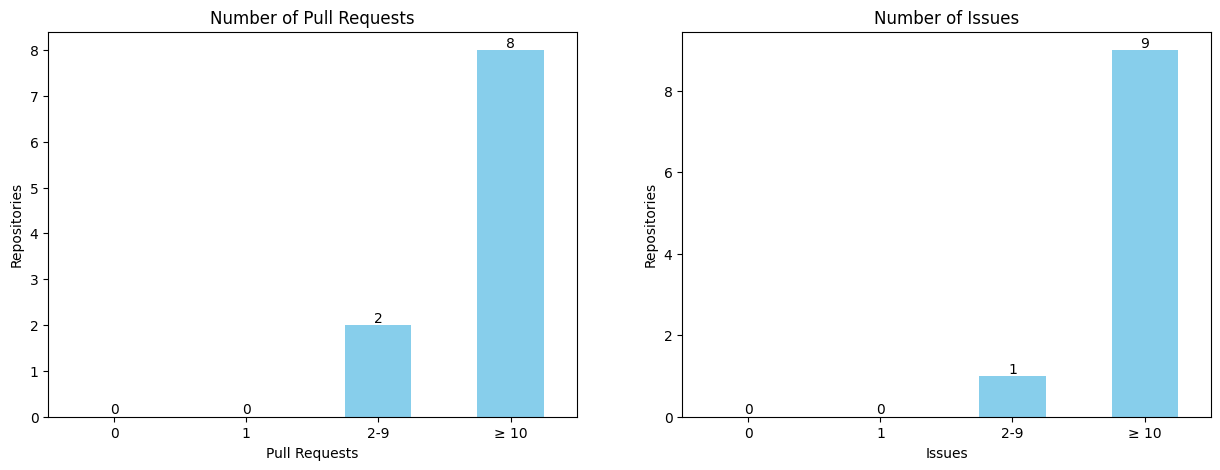

In [18]:
fig9, ax9 = plt.subplots( figsize=(15, 5), ncols=2)

pull_requests = selected.pull_requests\
    .value_counts(dropna=False, bins = [-1, 0,1, 9, 100000])\
    .sort_index().to_frame("Repositories")
pull_requests.plot.bar(title='Number of Pull Requests', color='skyblue', ax=ax9[0],
                   xlabel='Pull Requests', ylabel='Repositories').get_legend().remove()

ax9[0].set_xticks(ticks=[0, 1, 2, 3], labels=['0', '1','2-9', '≥ 10'], rotation=0)
ax9[0].bar_label(ax9[0].containers[0], label_type='edge')


issues = selected.issues\
    .value_counts(dropna=False, bins = [-1, 0, 1, 9, 100000])\
    .sort_index().to_frame("Repositories")

issues.plot.bar(title='Number of Issues', color='skyblue', ax=ax9[1],
                   xlabel='Issues', ylabel='Repositories').get_legend().remove()

ax9[1].set_xticks(ticks=[0, 1, 2, 3], labels=['0', '1','2-9', '≥ 10'], rotation=0)
ax9[1].bar_label(ax9[1].containers[0], label_type='edge');


### Watchers, Forks, Stargazers and Releases

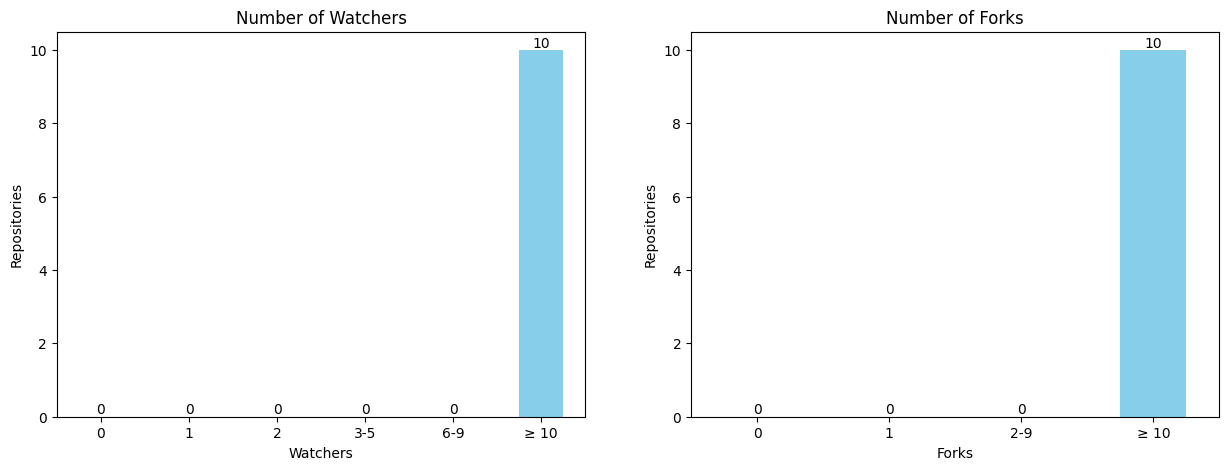

In [19]:
fig10, ax10 = plt.subplots( figsize=(15, 5), ncols=2)


watchers = selected.watchers\
    .value_counts(dropna=False, bins = [-1, 0,1,2,5,9, 100000])\
    .sort_index().to_frame("Repositories")

watchers.plot.bar(title='Number of Watchers', color='skyblue', ax=ax10[0],
                   xlabel='Watchers', ylabel='Repositories').get_legend().remove()

ax10[0].set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['0', '1', '2', '3-5', '6-9', '≥ 10'], rotation=0)
ax10[0].bar_label(ax10[0].containers[0], label_type='edge')


forks = selected.forks\
    .value_counts(dropna=False, bins = [-1, 0, 1, 9, 100000])\
    .sort_index().to_frame("Repositories")

forks.plot.bar(title='Number of Forks', color='skyblue', ax=ax10[1],
                   xlabel='Forks', ylabel='Repositories').get_legend().remove()
ax10[1].set_xticks(ticks=[0, 1, 2, 3], labels=['0', '1','2-9', '≥ 10'], rotation=0)
ax10[1].bar_label(ax10[1].containers[0], label_type='edge');

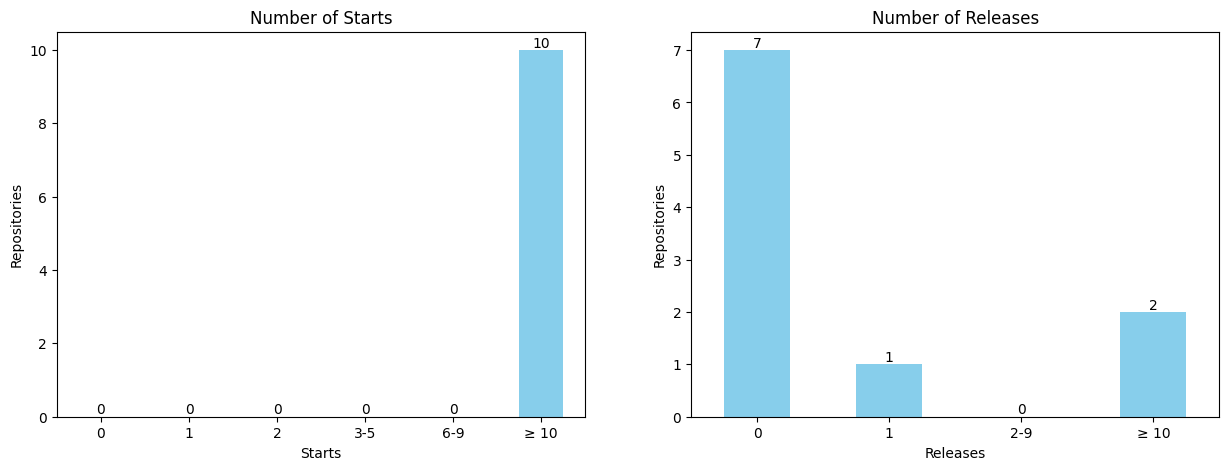

In [20]:
fig11, ax11 = plt.subplots( figsize=(15, 5), ncols=2)

stars = selected.stargazers\
    .value_counts(dropna=False, bins = [-1, 0,1,2,5,9, 100000])\
    .sort_index().to_frame("Repositories")

stars.plot.bar(title='Number of Starts', color='skyblue', ax=ax11[0],
                   xlabel='Starts', ylabel='Repositories').get_legend().remove()

ax11[0].set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['0', '1','2', '3-5', '6-9', '≥ 10'], rotation=0)
ax11[0].bar_label(ax11[0].containers[0], label_type='edge')

releases = selected.releases\
    .value_counts(dropna=False, bins = [-1, 0, 1, 9, 100000])\
    .sort_index().to_frame("Repositories")

releases.plot.bar(title='Number of Releases', color='skyblue', ax=ax11[1],
                   xlabel='Releases', ylabel='Repositories').get_legend().remove()

ax11[1].set_xticks(ticks=[0, 1, 2, 3], labels=['0', '1','2-9', '≥ 10'], rotation=0)
ax11[1].bar_label(ax11[1].containers[0], label_type='edge');

### Disk Usage

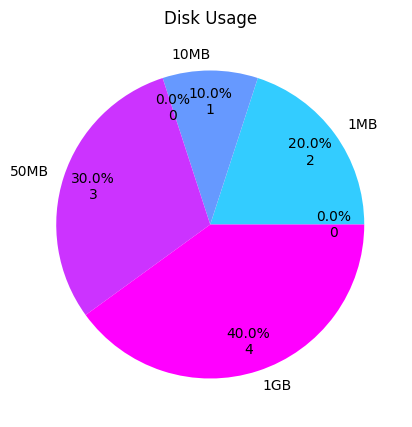

In [21]:
fig12, ax12 = plt.subplots( figsize=(6, 5))

disk_usage = selected.disk_usage.astype(int)\
    .value_counts(dropna=False, bins = [-1, 0, 10**3, 10*10**3, 20*10**3, 50*10**3,10**6])\
    .sort_index().to_frame("Repositories")
disk_usage.plot.pie(ax=ax12,y='Repositories', labels=['<1MB', '1MB', '10MB', '20MB', '50MB', '1GB'],
              pctdistance=0.8, ylabel='',
              autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'
                        .format(prct_value, (len(selected) * prct_value / 100))),
              cmap="cool").get_legend().remove()
ax12.set_title("Disk Usage");

### Repository Creation and Average Duration

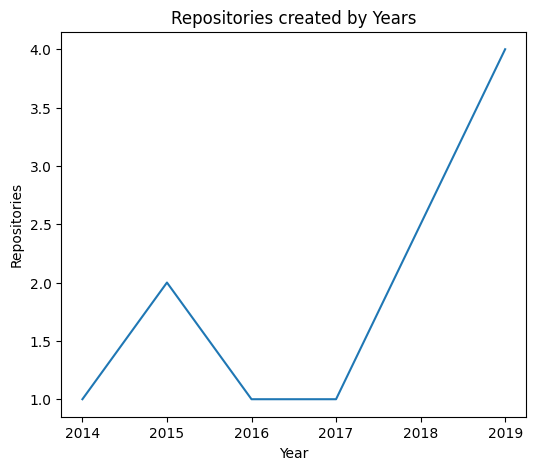

In [24]:
fig13, ax13 = plt.subplots( figsize=(6, 5))
creation = pd.to_datetime(selected['git_created_at']).dt.year.value_counts(dropna=False)\
    .sort_index().to_frame("Repositories")
creation = creation.drop(index=creation.index[-1])
creation.plot(ax=ax13, y='Repositories').get_legend().remove()

ax13.set_xlabel('Year')
ax13.set_ylabel('Repositories')
ax13.set_title('Repositories created by Years');

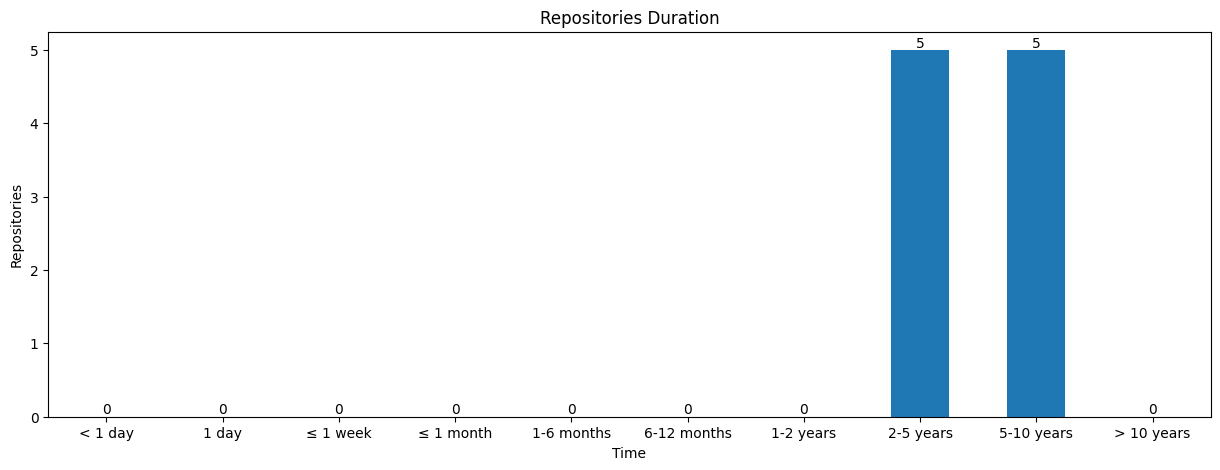

In [25]:
fig14, ax14 = plt.subplots( figsize=(15, 5))
dates = selected[['repository', 'git_created_at', 'git_pushed_at']]
dates =  dates.dropna(subset=['git_created_at'])
dates =  dates.dropna(subset=['git_pushed_at'])
dates["interval"] =  dates.git_pushed_at - dates.git_created_at
dates["interval_days"] = dates["interval"].dt.days.astype(int).abs()

duration = dates['interval_days'].value_counts(dropna=False, bins = [-1, 0,1,7,30,180, 365, 730, 1825, 3650, 100000])\
    .sort_index().to_frame("Repositories")

duration.plot.bar(ax=ax14, y="Repositories",
                  xlabel='Time', ylabel='Repositories').get_legend().remove()

ax14.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                labels=['< 1 day', '1 day','≤ 1 week', '≤ 1 month', '1-6 months',
                        '6-12 months','1-2 years', '2-5 years', '5-10 years', '> 10 years'], rotation=0)
ax14.bar_label(ax14.containers[0], label_type='edge')
ax14.set_title('Repositories Duration');